<table align="right" width=100%>
    <tr>
        <td width="20%">
            <img src="hcg-logo.png">
        </td>
        <td>
            <div align="center">
                <font color="#21618C" size=6px>
                  <b> CAPSTONE PROJECT DSE </b> 
                </font>
            </div>
            <div align="center">
                <font color="#21618C" size=6px>
                    <b> Home Credit Part 3: Base Models and Feature Selection </b>
                </font>
             </div>
        </td>
    </tr>
</table>

# Welcome to Part 3 of the Home Credit Capstone Project 

By now we have managed to extract 57 new features from the additional tables provided to us by home credit and also we handled the null values in our dataset by creating two different datasets and finally generated two new CSV files:
- application_data_cleaned_1.csv
- application_data_cleaned_2.csv

Further in Part 2 we tackled our next challenge to further enhance our data and prepare it for ML models. We simplified categorical features, transformed highly skewed numerical features, scaled them and created dummy for categorical features.

Finally, we created a Logistice Regression base model which currently sits at 0.51 ROC_AUC score.

Therefore, in this notebook, we aim to further enhance the performance of our model using various methods laid down below:
- Dimensionality Reduction
- Treating Multicollinearity

<a id="home"></a>
## Table of Content (...in continuation)

- **[Import Libraries](#lib)**

- **[Creating Functions for Ease of Coding](#func)**

8. **[Feature Elimination using VIF](#vif)**

9. **[Feature Selection from Best Model](#selection)**
    - 9.1 - **[Logistic Regression](#lr)**
    - 9.2 - **[Decision Tree Model](#dt)**
    - 9.3 - **[RandomForrest Model](#rf)**
    - 9.4 - **[XGBoost Model](#xgb)**
    - 9.5 - **[LGBoost Model](#lgb)**
    - 9.6 - **[Base Models Performance Summary](#summary)**
    - 9.7 - **[Selecting Top 40 features from Best Model](#top_40)**
    
- **[Summary of Dimensionality Reduction](#dr_summary)**

<a id="lib"></a>
# Import Libraries

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# to suppress warnings 
from warnings import filterwarnings
filterwarnings('ignore') 

#for displaying max columns
pd.pandas.set_option('display.max_columns', None)


# import train-test split 
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score, confusion_matrix, f1_score,recall_score

<a id="func"></a>
# Functions for Ease of Coding

## 1. Function to plot a confusion matrix

In [2]:
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    conf_matrix = pd.DataFrame(data = cm,columns = ['Predicted:0','Predicted:1'], index = ['Actual:0','Actual:1'])

    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = ListedColormap(['lightskyblue']), cbar = False, 
                linewidths = 0.1, annot_kws = {'size':25})

    # set the font size of x-axis ticks using 'fontsize'
    plt.xticks(fontsize = 20)

    # set the font size of y-axis ticks using 'fontsize'
    plt.yticks(fontsize = 20)

    # display the plot
    plt.show()

## 2. Function to plot a roc_auc_curve 

In [3]:
def plot_roc_auc(model, X_test, y_test):

    plt.figure(figsize=(10,6))
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # the roc_curve() returns the values for false positive rate, true positive rate and threshold
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    #model

    # plot the ROC curve
    plt.plot(fpr, tpr)

    # set limits for x and y axes
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])

    # plot the straight line showing worst prediction for the model
    plt.plot([0, 1], [0, 1],'r--')

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('ROC curve for Loan Defaulter Prediction', fontsize = 15)
    plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
    plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)

    # add the AUC score to the plot
    # 'x' and 'y' gives position of the text
    # 's' is the text 
    # use round() to round-off the AUC score upto 4 digits
    plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(roc_auc_score(y_test, y_pred_prob),4)))

    # plot the grid
    plt.grid(True)

## 3. Function to Return scaled and dummy for X and y for Model Building

In [4]:
def dataset_processing(df, encoding='ohe',scaling='standard'):
    print("Shape of the Dataset Provided: ", df.shape)
    
    #scaling numeric features
    df_num = df.select_dtypes('number')
    num_cols =df_num.nunique()
    binary_cols = num_cols[num_cols<4].index
    df_num = df_num.drop(binary_cols, axis=1)
    
    if scaling=='minmax':
        
        from sklearn.preprocessing import MinMaxScaler
        
        mm = MinMaxScaler(feature_range = (0, 1))
        scaled = mm.fit_transform(df_num)
        
        df_scaled = pd.DataFrame(scaled, columns=df_num.columns)
        print("MinaMax Scaling Done...")
        
    elif scaling=='standard':
        df_scaled = (df_num - df_num.mean())/df_num.std()
        print("Standard Scaling Done...")
    
    elif scaling=='no':
        # not applying scaling
        df_scaled = df_num
        print("Not applying Scaling...")
        
    # Catch error if scaling scheme is not valid
    else:
        raise ValueError("Scaling must be either 'minmax' or 'standard' or 'no'")
        
        
    #creating dummies:
    df_cat = df.select_dtypes('object')
    
    if encoding=='ohe':
        df_cat = pd.get_dummies(df_cat, drop_first=True)
        print('Dummies Created...')
        
    # Integer label encoding
    elif encoding == 'le':
        
        from sklearn.preprocessing import LabelEncoder
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # Iterate through each column
        for col in df_cat.columns:
            df_cat[col] = label_encoder.fit_transform(np.array(df_cat[col].astype(str)).reshape((-1,)))
        
        print("Label Encoding Done...")
                
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
        
    df_final = pd.concat([df_scaled, df_cat],axis=1,join='inner')
    df_final = pd.concat([df[binary_cols], df_final], axis=1, join='inner')
    
    print("Processed Datset Shape: ", df_final.shape)
    
    X = df_final.drop('TARGET',axis=1)
    y = df_final['TARGET']
    
    return X, y

## 4. Model Building Pipeline Function (latest version)

In [5]:
def build_model_pipeline(model_name, X,y, plot_graphs=False,feature_importance = False,over_sampling=False):
    
    # For over sampling
    if over_sampling==True:
        oversample = SMOTE()
        X, y = oversample.fit_resample(X, y)
        print('Over Sampling Done using SMOTE')
    
    
    X_train,X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=10)
    print('Train Test Split Done...')

    #X_train.shape , X_test.shape, y_train.shape, y_test.shape
    
    model = model_name

    model.fit(X_train,y_train)
    print('Model Fitted...')

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    if plot_graphs == True:
        
        print(classification_report(y_train, y_pred_train))
        
        print(classification_report(y_test, y_pred_test))
        
        plot_confusion_matrix(model, X_test, y_test)
        
        plot_roc_auc(model, X_test, y_test)
    else:
        print(classification_report(y_train, y_pred_train))
        print(classification_report(y_test, y_pred_test))
    
    # saving performance metrics for the mode
    
    eval_metrics = [accuracy_score(y_test, y_pred_test), recall_score(y_test, y_pred_test),f1_score(y_test, y_pred_test), roc_auc_score(y_test, y_pred_prob)]
    
    if feature_importance == True:
        important_features = pd.DataFrame({'Features': X_train.columns, 
                                       'Importance': model.feature_importances_})
        # sort the dataframe in the descending order according to the feature importance
        
        df_feature_importance = important_features.sort_values('Importance', ascending = False)

        return df_feature_importance, eval_metrics
    
    else: 
        return eval_metrics

## 5. Function for Systematic VIF elimination

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

def vif_calc(df, thresh):
    VIF = [vif(df.values, i) for i in range(df.shape[1])]
    df_vif = pd.DataFrame({'vif': VIF[:]}, index=df.columns)
    
    #iteration to check the progress of loop
    i = 1 
    
    while(df_vif.max().values>thresh):
        print("In Iteration no.", i)
        print("Dropping Feature: ", df_vif.sort_values(by='vif' ,ascending=False).head(1).index)
        
        i+=1
        
        df = df.drop(df_vif.sort_values(by='vif' ,ascending=False).head(1).index, axis=1) # dropping feature with highest vif
        
        VIF = [vif(df.values, i) for i in range(df.shape[1])]
        df_vif = pd.DataFrame({'vif': VIF[:]}, index=df.columns)
    
    return df, df_vif

## 6. Dataframes for saving various combination of Model Scores

In [164]:
# Logistic Regression

model_scores = pd.DataFrame(columns=['Accuracy_score', 'Recall_score','F1_score', 'ROC_AUC_Score'])


## 7. Function to Plot Feature Importance

In [8]:
def plot_feature_importance(df):
    plt.figure(figsize=(10,6))
    
    # create a barplot to visualize the features based on their importance
    sns.barplot(x = 'Importance', y = 'Features', data = df.head(15))

    # add plot and axes labels
    # set text size using 'fontsize'
    plt.title('Feature Importance', fontsize = 12)
    plt.xlabel('Importance', fontsize = 12)
    plt.ylabel('Features', fontsize = 12)

    # display the plot
    plt.show()

## Loading Cleaned and Processed Dataset 1 and 2:

In [43]:
df1 = pd.read_csv('cleaned_dataset_1_latest.csv')
#df2 = pd.read_csv('cleaned_dataset_2_latest.csv')

In [44]:
df1 = df1.drop(['Unnamed: 0'],axis=1)
#df2 = df2.drop(['Unnamed: 0','index'],axis=1)

In [97]:
df1.shape #df2.shape

(212051, 115)

In [46]:
df1.head()

,TARGET,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,ORGANIZATION_TYPE,OCCUPATION_TYPE,FLAG_BUREAU_ACCOUNT,FLAG_CREDIT_CARD,FLAG_PREV_APP,FLAG_LOAN_ACCOUNTS_IP,FLAG_LOAN_ACCOUNTS_POS,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_BUREAU_ACCOUNTS,PERCENT_ConsumerCredit_CREDIT_TYPE,PERCENT_CREDIT_ACTIVE,TOTAL_CUSTOMER_CREDIT,DEBT_PERCENT,TOTAL_CUSTOMER_OVERDUE,OVERDUE_DEBT_PERCENT,ACCOUNT_AGE(in months),PERCENT_DURATION_STATUS_CLOSED,PERCENT_ON_TIME_PAYMENT_BUREAU,TOTAL_PREV_APP,PERCENT_AVAILED_INSURANCE,AVG_AMT_ANNUITY,STD_AMT_ANNUITY,AVG_AMT_APPLICATION,STD_AMT_APPLICATION,AVG_AMT_CREDIT,STD_AMT_CREDIT,AVG_AMT_GOODS_PRICE,STD_AMT_GOODS_PRICE,AVG_CNT_PAYMENT,STD_CNT_PAYMENT,prev_Cash_loans,prev_Consumer_loans,prev_Revolving_loans,prev_status_Approved,prev_status_Canceled,prev_status_Refused,prev_status_Unused,prev_Family,prev_Others,prev_Unaccompanied,CLIENT_TYPE_New,CLIENT_TYPE_Refreshed,CLIENT_TYPE_Repeater,prev_Cards,prev_Cash,prev_POS,YIELD_GROUP_high,YIELD_GROUP_low,YIELD_GROUP_middle,TOTAL_COUNT_CC,PERCENT_ON_TIME_PAYMENT_CC,AVG_CREDIT_LIMIT,PERCENAT_CC_ACTIVE,PERCENAT_CC_Completed,TOTAL_INSTALLMENTS_POS,TOTAL_LOAN_ACCOUNTS_POS,PERCENT_POS_ACTIVE,PERCENT_POS_Completed,PERCENT_ON_TIME_POS,TOTAL_INSTALLMENTS,TOTAL_LOAN_ACCOUNTS_IP,PERCENT_ON_TIME_INSTALLMENTS,FLAG_DOCUMENT_SUM,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,YEARSDAYS_DIFF,YEARSDAYS_DECISION_prev,EMPLOYMENT_AGE_RATIO,CREDIT_INCOME_RATIO,INCOME_PER_PERSON,ANNUITY_INCOME_RATIO,PAYMENT_RATE,GOODS_INCOME_RATIO,GOODS_CREDIT_RATIO
0,0,1,1,1,0,0,0,0,0,0,0,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary_Education,Unmarried,Own House,OTHERS,LOWER_SKILL,YES,NO,YES,YES,YES,0.0,16.118549,367.423461,82.158384,367.423461,1.000000,2,2,9,0.555912,0.729567,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,1.414214,100.0000,0.0000,20.851493,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,73.193237,0.000000,155.826827,0.000000,141.795628,0.000000,155.826827,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000,1.0,0.0,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,2.000000,1.000000,2.942831,5.000000,3.162278,1.732051,1.000000,3.162278,0.000000,52.180822,0.785136,11.671233,6.934247,2.232877,1.121398,2.232877,0.015046,22.795071,16.118549,5.097133,4.472136,22.795071,1.000000
1,0,1,0,0,0,0,0,0,0,0,0,Cash loans,F,N,Y,Unaccompanied,Working,Secondary_Education,Married,Own House,Business,LOWER_SKILL,NO,YES,YES,YES,YES,0.0,19.168293,559.180204,172.297707,544.977064,1.414214,2,2,17,0.650442,0.509149,1.414214,0.0,1.414214,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0000,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,3.000000,0.0,153.789401,116.720093,521.731023,534.953390,540.088419,577.353748,638.987394,503.657225,4.795832,4.497777,2.236068,1.414214,1.189207,2.236068,1.316074,1.0,0.0,1.000000,0.0,1.732051,1.0,0.0,2.828427,1.0,1.732051,1.414214,1.414214,1.414214,1.000000,1.565085,10.0,22.795071,10.0,0.0,4.582576,1.732051,3.042729,3.086067,3.162278,4.000000,1.732051,3.162278,1.084391,52.068493,2.885486,26.939726,6.676712,1.690411,0.000000,0.746423,0.055417,29.172144,13.554030,8.988683,3.245430,28.431173,0.974600
2,0,1,0,0,0,0,0,0,0,1,1,Cash loans,M,N,Y,Unaccompanied,Working,Secondary_Education,Unmarried,Own House,OTHERS,HIGHER_SK

- Since, we have already built base models previously and we observed the poor performance of our base model.
- Now, we will find the least important features from the model and eliminate them and further treat multicollinearity to further reduce the features.

In [98]:
# Calling data_processing functiion to get X, y

X, y = dataset_processing(df1) # default encoding and scaling

Shape of the Dataset Provided:  (212051, 115)
Standard Scaling Done...
Dummies Created...
Processed Datset Shape:  (212051, 125)


In [99]:
X.shape, y.shape

((212051, 124), (212051,))

In [100]:
X.head(2)

,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_BUREAU_ACCOUNTS,PERCENT_ConsumerCredit_CREDIT_TYPE,PERCENT_CREDIT_ACTIVE,TOTAL_CUSTOMER_CREDIT,DEBT_PERCENT,TOTAL_CUSTOMER_OVERDUE,OVERDUE_DEBT_PERCENT,ACCOUNT_AGE(in months),PERCENT_DURATION_STATUS_CLOSED,PERCENT_ON_TIME_PAYMENT_BUREAU,TOTAL_PREV_APP,PERCENT_AVAILED_INSURANCE,AVG_AMT_ANNUITY,STD_AMT_ANNUITY,AVG_AMT_APPLICATION,STD_AMT_APPLICATION,AVG_AMT_CREDIT,STD_AMT_CREDIT,AVG_AMT_GOODS_PRICE,STD_AMT_GOODS_PRICE,AVG_CNT_PAYMENT,STD_CNT_PAYMENT,prev_Cash_loans,prev_Consumer_loans,prev_Revolving_loans,prev_status_Approved,prev_status_Canceled,prev_status_Refused,prev_status_Unused,prev_Family,prev_Others,prev_Unaccompanied,CLIENT_TYPE_New,CLIENT_TYPE_Refreshed,CLIENT_TYPE_Repeater,prev_Cards,prev_Cash,prev_POS,YIELD_GROUP_high,YIELD_GROUP_low,YIELD_GROUP_middle,TOTAL_COUNT_CC,PERCENT_ON_TIME_PAYMENT_CC,AVG_CREDIT_LIMIT,PERCENAT_CC_ACTIVE,PERCENAT_CC_Completed,TOTAL_INSTALLMENTS_POS,TOTAL_LOAN_ACCOUNTS_POS,PERCENT_POS_ACTIVE,PERCENT_POS_Completed,PERCENT_ON_TIME_POS,TOTAL_INSTALLMENTS,TOTAL_LOAN_ACCOUNTS_IP,PERCENT_ON_TIME_INSTALLMENTS,FLAG_DOCUMENT_SUM,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,YEARSDAYS_DIFF,YEARSDAYS_DECISION_prev,EMPLOYMENT_AGE_RATIO,CREDIT_INCOME_RATIO,INCOME_PER_PERSON,ANNUITY_INCOME_RATIO,PAYMENT_RATE,GOODS_INCOME_RATIO,GOODS_CREDIT_RATIO,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Others,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Lower_Education,NAME_EDUCATION_TYPE_Secondary_Education,NAME_FAMILY_STATUS_Separated/Widow,NAME_FAMILY_STATUS_Unmarried,NAME_HOUSING_TYPE_Rented/Others,ORGANIZATION_TYPE_EDUCATION,ORGANIZATION_TYPE_INDUSTRY,ORGANIZATION_TYPE_OTHERS,ORGANIZATION_TYPE_Self-employed,OCCUPATION_TYPE_LOWER_SKILL,OCCUPATION_TYPE_MEDIUM_SKILL,FLAG_BUREAU_ACCOUNT_YES,FLAG_CREDIT_CARD_YES,FLAG_PREV_APP_YES,FLAG_LOAN_ACCOUNTS_IP_YES,FLAG_LOAN_ACCOUNTS_POS_YES
0,1,1,1,0,0,0,0,0,0,0,2,2,-0.653487,-1.454327,-1.452663,-1.829115,-1.354665,-1.458961,-0.931838,0.261573,1.283226,-0.828199,-0.361308,-0.824741,-0.304442,-0.168215,-0.392095,-0.440466,-1.156487,-0.396132,1.038306,-1.098764,-0.406043,-1.04674,-0.081089,-0.074499,-0.633868,-0.540532,-0.639244,-1.012225,-0.831139,-0.806266,-1.280732,-1.066318,-1.221363,-1.193509,-1.231408,-1.134072,-1.108177,-1.138154,-1.251932,-0.882197,-0.156543,-0.665552,-0.467607,-0.688546,-0.648302,-0.236677,-0.905173,-0.266723,0.193183,0.643156,-0.53462,-1.142554,-0.643603,-0.819256,-0.125644,-0.888162,-0.959963,0.425379,-0.595526,-0.622079,-0.598578,-0.621165,-0.1791,-1.237268,-0.791590,0.027609,1.936577,0.25978,-1.236016,-0.871136,0.317794,-1.689042,0.701746,-0.807243,-0.176614,-0.299497,-0.165105,1.189877,-0.089729,-1.003458,-1.228962,0.543763,-1.607404,-0.106682,-1.109707,1.038594,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,1
1,1,0,0,0,0,0,0,0,0,0,2,2,-0.653487,-0.185352,-0.675108,0.346919,-0.602293,-0.098060,1.545314,0.753278,0.025369,0.699868,-0.361308,0.710075,-0.304442,-0.168215,-0.392095,-0.440466,-1.156487,-1.678754,-1.719690,-1.098764,-1.800617,-1.04674,-0.081089,-0.074499,-0.633868,-0.540532,-0.639244,1.155834,-0.831139,1.073897,1.047882,1.085244,1.133130,1.039238,1.199662,1.361210,1.012965,1.013136,1.376141,1.255602,0.373913,1.664639,0.981001,1.614623,1.130128,-0.23667

In [26]:
y.head(2)

0    0
1    0
Name: TARGET, dtype: int64

<a id="vif"></a>

# [8. Handling Multicollinearity and Dropping Features using VIF](#home)

### Systematically Dropping Features by changing the Threshold values step by step

In [103]:
# segergating categorical dummies

num_cols =X.nunique()
binary_cols = num_cols[num_cols<=5].index

In [104]:
X_num = X.drop(binary_cols,axis=1)
X_num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,CNT_FAM_MEMBERS,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_BUREAU_ACCOUNTS,PERCENT_ConsumerCredit_CREDIT_TYPE,PERCENT_CREDIT_ACTIVE,TOTAL_CUSTOMER_CREDIT,DEBT_PERCENT,TOTAL_CUSTOMER_OVERDUE,OVERDUE_DEBT_PERCENT,ACCOUNT_AGE(in months),PERCENT_DURATION_STATUS_CLOSED,PERCENT_ON_TIME_PAYMENT_BUREAU,TOTAL_PREV_APP,PERCENT_AVAILED_INSURANCE,AVG_AMT_ANNUITY,STD_AMT_ANNUITY,AVG_AMT_APPLICATION,STD_AMT_APPLICATION,AVG_AMT_CREDIT,STD_AMT_CREDIT,AVG_AMT_GOODS_PRICE,STD_AMT_GOODS_PRICE,AVG_CNT_PAYMENT,STD_CNT_PAYMENT,prev_Cash_loans,prev_Consumer_loans,prev_Revolving_loans,prev_status_Approved,prev_status_Canceled,prev_status_Refused,prev_status_Unused,prev_Family,prev_Others,prev_Unaccompanied,CLIENT_TYPE_New,CLIENT_TYPE_Refreshed,CLIENT_TYPE_Repeater,prev_Cards,prev_Cash,prev_POS,YIELD_GROUP_high,YIELD_GROUP_low,YIELD_GROUP_middle,TOTAL_COUNT_CC,PERCENT_ON_TIME_PAYMENT_CC,AVG_CREDIT_LIMIT,PERCENAT_CC_ACTIVE,PERCENAT_CC_Completed,TOTAL_INSTALLMENTS_POS,TOTAL_LOAN_ACCOUNTS_POS,PERCENT_POS_ACTIVE,PERCENT_POS_Completed,PERCENT_ON_TIME_POS,TOTAL_INSTALLMENTS,TOTAL_LOAN_ACCOUNTS_IP,PERCENT_ON_TIME_INSTALLMENTS,FLAG_DOCUMENT_SUM,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,YEARSDAYS_DIFF,YEARSDAYS_DECISION_prev,EMPLOYMENT_AGE_RATIO,CREDIT_INCOME_RATIO,INCOME_PER_PERSON,ANNUITY_INCOME_RATIO,PAYMENT_RATE,GOODS_INCOME_RATIO,GOODS_CREDIT_RATIO
0,-0.653487,-1.454327,-1.452663,-1.829115,-1.354665,-1.458961,-0.931838,0.261573,1.283226,-0.828199,-0.361308,-0.824741,-0.304442,-0.168215,-0.392095,-0.440466,-1.156487,-0.396132,1.038306,-1.098764,-0.406043,-1.046740,-0.081089,-0.074499,-0.633868,-0.540532,-0.639244,-1.012225,-0.831139,-0.806266,-1.280732,-1.066318,-1.221363,-1.193509,-1.231408,-1.134072,-1.108177,-1.138154,-1.251932,-0.882197,-0.156543,-0.665552,-0.467607,-0.688546,-0.648302,-0.236677,-0.905173,-0.266723,0.193183,0.643156,-0.53462,-1.142554,-0.643603,-0.819256,-0.125644,-0.888162,-0.959963,0.425379,-0.595526,-0.622079,-0.598578,-0.621165,-0.1791,-1.237268,-0.791590,0.027609,1.936577,0.259780,-1.236016,-0.871136,0.317794,-1.689042,0.701746,-0.807243,-0.176614,-0.299497,-0.165105,1.189877,-0.089729,-1.003458,-1.228962,0.543763,-1.607404,-0.106682,-1.109707,1.038594
1,-0.653487,-0.185352,-0.675108,0.346919,-0.602293,-0.098060,1.545314,0.753278,0.025369,0.699868,-0.361308,0.710075,-0.304442,-0.168215,-0.392095,-0.440466,-1.156487,-1.678754,-1.719690,-1.098764,-1.800617,-1.046740,-0.081089,-0.074499,-0.633868,-0.540532,-0.639244,1.155834,-0.831139,1.073897,1.047882,1.085244,1.133130,1.039238,1.199662,1.361210,1.012965,1.013136,1.376141,1.255602,0.373913,1.664639,0.981001,1.614623,1.130128,-0.236677,0.525966,-0.266723,1.101908,0.643156,-0.53462,1.239730,1.446163,1.200372,0.419734,1.061140,0.942006,0.425379,0.889785,1.628567,1.873973,1.640874,-0.1791,-0.088730,0.385277,0.173506,0.466660,0.259780,-0.465347,0.295574,0.317794,-0.196070,0.692333,0.760027,1.431448,-0.361931,-0.407236,-1.349043,-1.001466,0.255493,-0.673392,-0.184241,0.514547,-1.549076,-0.594190,0.533782
2,-0.653487,-0.392692,-0.038245,-0.242788,0.123424,-1.458961,-0.312550,-0.951304,-0.495189,-0.828199,-0.361308,-0.824741,-0.304442,-0.168215,-0.392095,-0.440466,-1.156487,-0.771804,1.038306,-1.098764,-0.492705,-1.046740,-0.081089,-0.074499,-0.633868,-0.540532,-0.639244,0.559065,1.085453,0.071259,0.510765,0.298785,0.174524,0.299978,0.215217,0.064895,0.227506,0.821228,0.961496,1.029909,0.373913,-0.665552,1.231120,-0.688546,-0.648302,-0.236677,1.118764,-0.266723,0.707363,0.643156,-0.53462,0.740807,-0.643603,1.512809,0.419734,1.499236,-0.959963,1.436465,-0.595526,-0.622079,-0.598578,-0.621165,-0.1791,1.486249,1.195550,0.276477,-0.266066,0.259780,0.936037,1.098854,-

In [105]:
X_num.shape

(212051, 86)

In [106]:
X_cat = X[binary_cols]
X_cat.head()

,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Others,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Lower_Education,NAME_EDUCATION_TYPE_Secondary_Education,NAME_FAMILY_STATUS_Separated/Widow,NAME_FAMILY_STATUS_Unmarried,NAME_HOUSING_TYPE_Rented/Others,ORGANIZATION_TYPE_EDUCATION,ORGANIZATION_TYPE_INDUSTRY,ORGANIZATION_TYPE_OTHERS,ORGANIZATION_TYPE_Self-employed,OCCUPATION_TYPE_LOWER_SKILL,OCCUPATION_TYPE_MEDIUM_SKILL,FLAG_BUREAU_ACCOUNT_YES,FLAG_CREDIT_CARD_YES,FLAG_PREV_APP_YES,FLAG_LOAN_ACCOUNTS_IP_YES,FLAG_LOAN_ACCOUNTS_POS_YES
0,1,1,1,0,0,0,0,0,0,0,2,2,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,1
1,1,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,1,1
2,1,0,0,0,0,0,0,0,1,1,2,2,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,1,1,1
3,1,1,1,0,0,0,0,0,0,0,2,2,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,1,1
4,1,0,1,0,0,0,0,0,0,0,2,2,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,1


In [107]:
# passing numeric datset 1 and checking results
# setting threshold to 100 initially

X_num , df_vif_result = vif_calc(X_num, thresh=100)

In Iteration no. 1
Dropping Feature:  Index(['AMT_GOODS_PRICE'], dtype='object')
In Iteration no. 2
Dropping Feature:  Index(['CREDIT_INCOME_RATIO'], dtype='object')
In Iteration no. 3
Dropping Feature:  Index(['OBS_60_CNT_SOCIAL_CIRCLE'], dtype='object')
In Iteration no. 4
Dropping Feature:  Index(['PERCENAT_CC_ACTIVE'], dtype='object')
In Iteration no. 5
Dropping Feature:  Index(['AMT_ANNUITY'], dtype='object')
In Iteration no. 6
Dropping Feature:  Index(['prev_Consumer_loans'], dtype='object')
In Iteration no. 7
Dropping Feature:  Index(['GOODS_INCOME_RATIO'], dtype='object')


In [108]:
df_vif_result.sort_values(by='vif',ascending=False).head(25)

,vif
TOTAL_LOAN_ACCOUNTS_IP,70.341434
TOTAL_LOAN_ACCOUNTS_POS,69.918009
STD_AMT_APPLICATION,68.960931
STD_AMT_CREDIT,61.227748
AVG_AMT_APPLICATION,60.398033
AVG_AMT_GOODS_PRICE,54.282133
AVG_AMT_CREDIT,43.301928
PERCENT_ON_TIME_PAYMENT_CC,41.008371
AMT_CREDIT,37.919854
PERCENT_ON_TIME_POS,36.377532


In [110]:
# passing numeric datset 1 and checking results
# setting threshold to 100 initially

X_num , df_vif_result = vif_calc(X_num, thresh=22)

In Iteration no. 1
Dropping Feature:  Index(['TOTAL_LOAN_ACCOUNTS_IP'], dtype='object')
In Iteration no. 2
Dropping Feature:  Index(['STD_AMT_APPLICATION'], dtype='object')
In Iteration no. 3
Dropping Feature:  Index(['AVG_AMT_APPLICATION'], dtype='object')
In Iteration no. 4
Dropping Feature:  Index(['AMT_CREDIT'], dtype='object')
In Iteration no. 5
Dropping Feature:  Index(['PERCENT_ON_TIME_PAYMENT_CC'], dtype='object')
In Iteration no. 6
Dropping Feature:  Index(['PERCENT_ON_TIME_POS'], dtype='object')
In Iteration no. 7
Dropping Feature:  Index(['AVG_AMT_GOODS_PRICE'], dtype='object')
In Iteration no. 8
Dropping Feature:  Index(['prev_status_Approved'], dtype='object')
In Iteration no. 9
Dropping Feature:  Index(['ACCOUNT_AGE(in months)'], dtype='object')
In Iteration no. 10
Dropping Feature:  Index(['prev_Cash_loans'], dtype='object')
In Iteration no. 11
Dropping Feature:  Index(['CNT_FAM_MEMBERS'], dtype='object')


In [113]:
df_vif_result.sort_values(by='vif',ascending=False).head(15)

,vif
EMPLOYMENT_AGE_RATIO,20.277469
prev_Cards,15.911908
YEARS_EMPLOYED,15.666314
CLIENT_TYPE_Repeater,15.624294
TOTAL_LOAN_ACCOUNTS_POS,15.274491
TOTAL_PREV_APP,14.550020
prev_Revolving_loans,14.436938
AVG_AMT_CREDIT,13.857232
STD_AMT_GOODS_PRICE,12.511291
STD_AMT_CREDIT,12.209174


In [114]:
X_num = X_num.drop(['STD_AMT_CREDIT','STD_AMT_GOODS_PRICE','prev_Cards','YEARS_EMPLOYED','prev_Revolving_loans','CLIENT_TYPE_Repeater'],
                  axis=1)

In [115]:
# passing numeric datset 1 and checking results
# setting threshold to 100 initially

X_num , df_vif_result = vif_calc(X_num, thresh=10)

In Iteration no. 1
Dropping Feature:  Index(['TOTAL_LOAN_ACCOUNTS_POS'], dtype='object')
In Iteration no. 2
Dropping Feature:  Index(['AVG_AMT_CREDIT'], dtype='object')
In Iteration no. 3
Dropping Feature:  Index(['TOTAL_COUNT_CC'], dtype='object')


In [116]:
vif_features_dropped = set(X.columns) - set(X_num.columns) - set(X_cat.columns)
len(vif_features_dropped)

27

In [163]:
vif_features_dropped

{'ACCOUNT_AGE(in months)',
 'AMT_ANNUITY',
 'AMT_CREDIT',
 'AMT_GOODS_PRICE',
 'AVG_AMT_APPLICATION',
 'AVG_AMT_CREDIT',
 'AVG_AMT_GOODS_PRICE',
 'CLIENT_TYPE_Repeater',
 'CNT_FAM_MEMBERS',
 'CREDIT_INCOME_RATIO',
 'GOODS_INCOME_RATIO',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'PERCENAT_CC_ACTIVE',
 'PERCENT_ON_TIME_PAYMENT_CC',
 'PERCENT_ON_TIME_POS',
 'STD_AMT_APPLICATION',
 'STD_AMT_CREDIT',
 'STD_AMT_GOODS_PRICE',
 'TOTAL_COUNT_CC',
 'TOTAL_LOAN_ACCOUNTS_IP',
 'TOTAL_LOAN_ACCOUNTS_POS',
 'YEARS_EMPLOYED',
 'prev_Cards',
 'prev_Cash_loans',
 'prev_Consumer_loans',
 'prev_Revolving_loans',
 'prev_status_Approved'}

In [117]:
## applying this result on the main dataset

df1_reduced = df1.drop(vif_features_dropped,axis=1)

In [118]:
df1_reduced.shape, df1.shape

((212051, 88), (212051, 115))

<a id='selection'></a>
# [9. Feature Selection](#home)

In [165]:
X,y = dataset_processing(df1_reduced)

Shape of the Dataset Provided:  (212051, 88)
Standard Scaling Done...
Dummies Created...
Processed Datset Shape:  (212051, 98)


### Fitting Random Forrest Model on the Reduced Dataset 1

<a id='lr'></a>
## [9.1 Checking Logistic Regression Model on Reduced Dataset](#home)

Train Test Split Done...
Model Fitted...
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    155052
           1       0.56      0.02      0.05     14588

    accuracy                           0.91    169640
   macro avg       0.74      0.51      0.50    169640
weighted avg       0.88      0.91      0.88    169640

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     38731
           1       0.50      0.02      0.04      3680

    accuracy                           0.91     42411
   macro avg       0.71      0.51      0.50     42411
weighted avg       0.88      0.91      0.88     42411



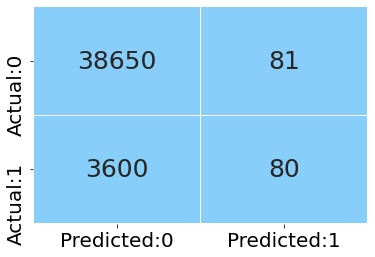

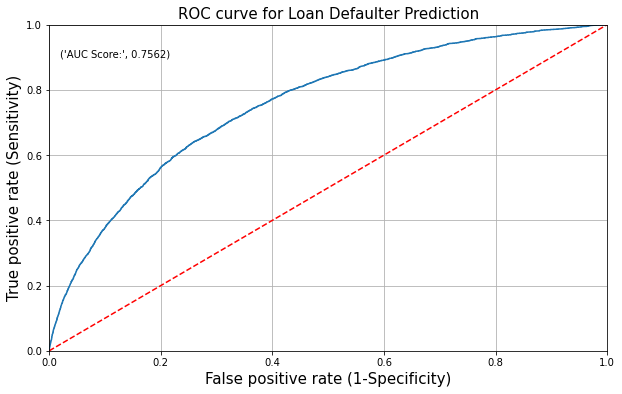

In [166]:
model_scores.loc['LR_Model'] = build_model_pipeline(LogisticRegression(), X,y,plot_graphs=True)

<a id='dt'></a>
## [9.2 Decision Tree Model on the Reduced Dataset 1](#home)

Train Test Split Done...
Model Fitted...
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    155052
           1       0.78      0.12      0.21     14588

    accuracy                           0.92    169640
   macro avg       0.85      0.56      0.58    169640
weighted avg       0.91      0.92      0.89    169640

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     38731
           1       0.31      0.04      0.08      3680

    accuracy                           0.91     42411
   macro avg       0.61      0.52      0.51     42411
weighted avg       0.86      0.91      0.88     42411



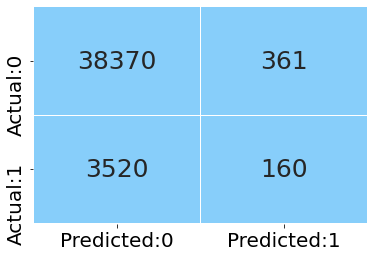

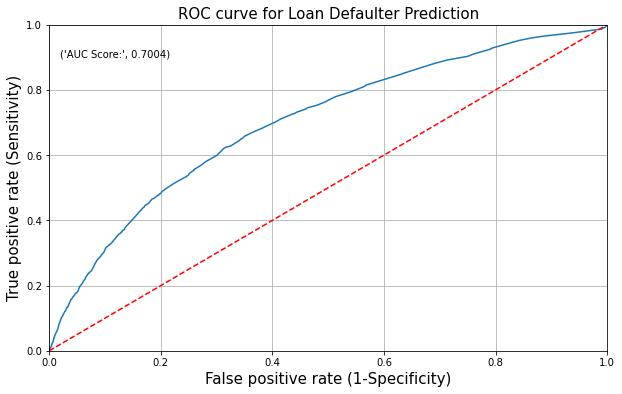

In [167]:
dt_feature_imp, model_scores.loc['DT_Model'] =  build_model_pipeline(DecisionTreeClassifier(max_depth=10), X,y,plot_graphs=True,
                                                                        feature_importance=True)

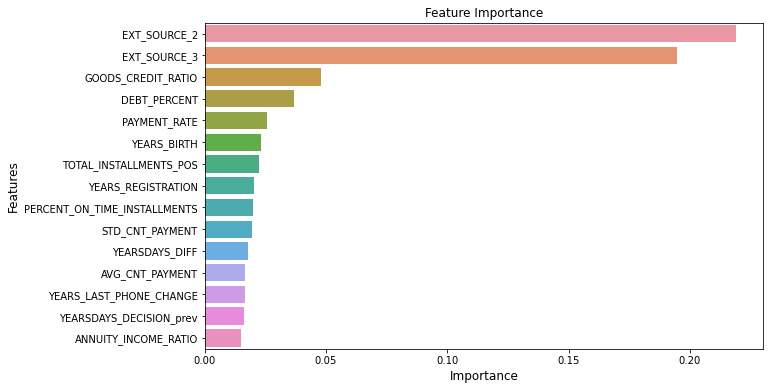

In [124]:
plot_feature_importance(dt_feature_imp)

<a id='rf'></a>
## [9.3 RandomForrest Model](#home)

Train Test Split Done...
Model Fitted...
              precision    recall  f1-score   support

           0       0.91      1.00      0.96    155052
           1       1.00      0.00      0.01     14588

    accuracy                           0.91    169640
   macro avg       0.96      0.50      0.48    169640
weighted avg       0.92      0.91      0.87    169640

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     38731
           1       1.00      0.00      0.00      3680

    accuracy                           0.91     42411
   macro avg       0.96      0.50      0.48     42411
weighted avg       0.92      0.91      0.87     42411



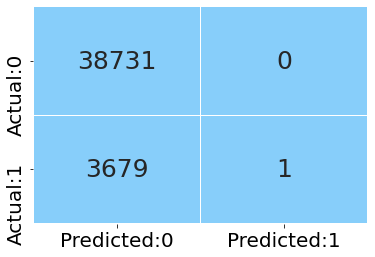

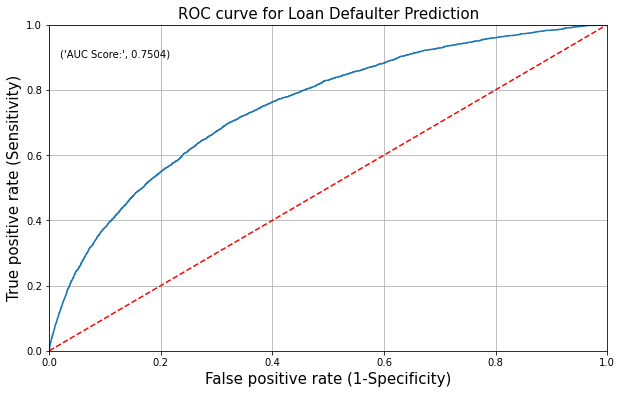

In [169]:
rf_feature_imp, model_scores.loc['RF_Model'] = build_model_pipeline(RandomForestClassifier(max_depth=10), X,y,plot_graphs=True,
                                                                        feature_importance=True)

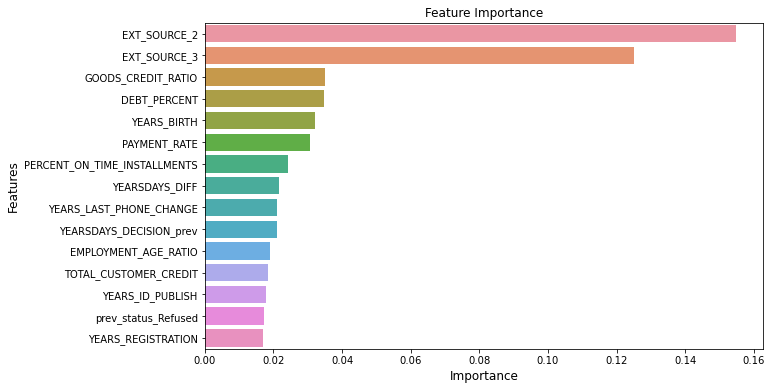

In [170]:
plot_feature_importance(rf_feature_imp)

<a id='xgb'></a>
## [9.4 XGBoost Base Model](#home)

Train Test Split Done...
[16:54:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Fitted...
              precision    recall  f1-score   support

           0       0.93      1.00      0.96    155052
           1       0.86      0.15      0.25     14588

    accuracy                           0.92    169640
   macro avg       0.89      0.57      0.61    169640
weighted avg       0.92      0.92      0.90    169640

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     38731
           1       0.48      0.06      0.10      3680

    accuracy                           0.91     42411
   macro avg       0.70      0.53      0.53     42411
weighted avg       0.88      0.91      0.88     42

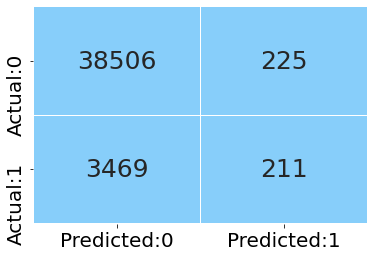

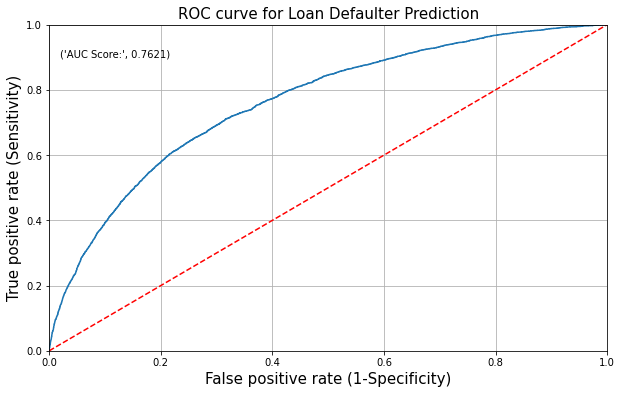

In [171]:
xgb_feature_imp, model_scores.loc['XGB_Model'] = build_model_pipeline(XGBClassifier(), X,y,plot_graphs=True,
                                                                        feature_importance=True)

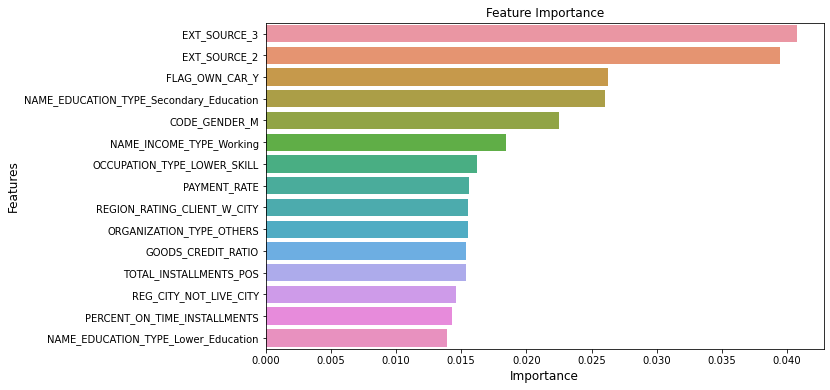

In [129]:
plot_feature_importance(xgb_feature_imp)

<a id='lgb'></a>
## [9.5 LightGradientBoost Base Model](#home)

In [130]:
lgb = LGBMClassifier()

Train Test Split Done...
Model Fitted...
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    155052
           1       0.74      0.05      0.09     14588

    accuracy                           0.92    169640
   macro avg       0.83      0.52      0.53    169640
weighted avg       0.90      0.92      0.88    169640

              precision    recall  f1-score   support

           0       0.92      1.00      0.95     38731
           1       0.53      0.03      0.06      3680

    accuracy                           0.91     42411
   macro avg       0.72      0.52      0.51     42411
weighted avg       0.88      0.91      0.88     42411



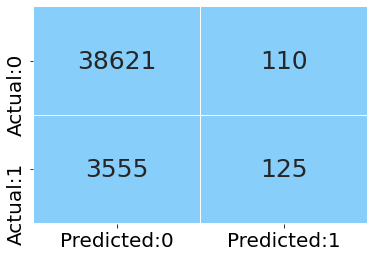

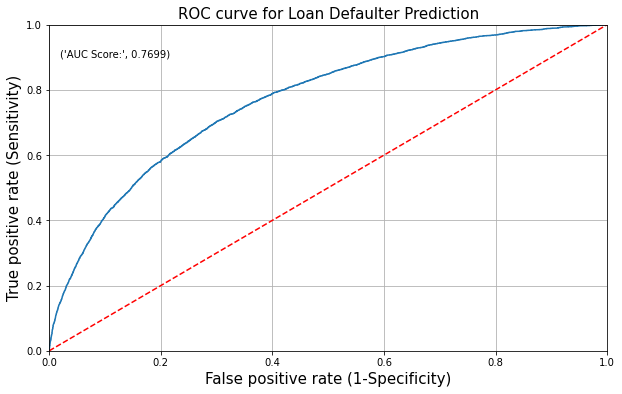

In [172]:
lgb_feature_imp, model_scores.loc['LGB_Model'] = build_model_pipeline(lgb, X,y,plot_graphs=True,
                                                                             feature_importance=True)

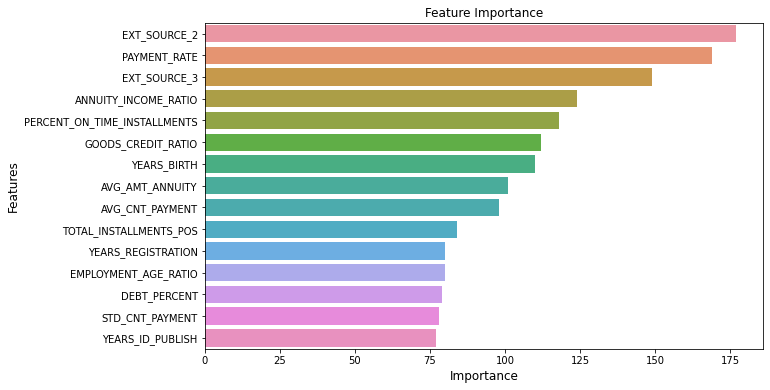

In [132]:
plot_feature_importance(lgb_feature_imp)

<a id='summary'></a>
## [9.6 Performance Summary of Fitted Models on Reduced Dataset 1 ](#home)

In [173]:
model_scores

,Accuracy_score,Recall_score,F1_score,ROC_AUC_Score
LR_Model,0.913206,0.021739,0.041656,0.756232
DT_Model,0.908491,0.043478,0.076172,0.700402
RF_Model,0.913254,0.000272,0.000543,0.750398
XGB_Model,0.912900,0.057337,0.102527,0.762111
LGB_Model,0.913584,0.033967,0.063857,0.769902


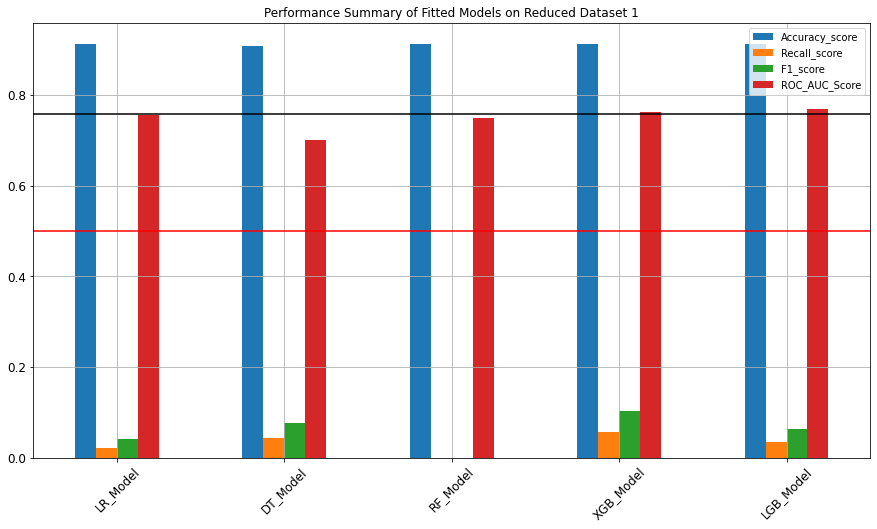

In [174]:
model_scores.plot(kind='bar', figsize=(15,8),title="Performance Summary of Fitted Models on Reduced Dataset 1",fontsize=12)
plt.grid()
plt.axhline(0.758278, color='black')
plt.axhline(0.5,color='r')
plt.xticks(rotation='45')
plt.show()

**Inference**:
- The LGB Model is having best AUC Score.
- However, XGBModel has a better Recall and F1 and almost similar AUC_score
- Hence, going with XGB Model for picking top 40 features to build our Final model

In [300]:
# saving the performance of Base Models in a csv file

model_scores.to_csv('base_model_scores_dataset1.csv')

<a id='top_40'></a>
## [9.7 Selecting Top 50 important features XGBoost Model](#home)

In [156]:
# creating cumulative sum of feat_importance

xgb_feature_imp.head()

,Features,Importance
16,EXT_SOURCE_3,0.040775
15,EXT_SOURCE_2,0.039469
74,FLAG_OWN_CAR_Y,0.026274
82,NAME_EDUCATION_TYPE_Secondary_Education,0.026025
72,CODE_GENDER_M,0.022513


In [147]:
features_to_keep = list(xgb_feature_imp['Features'].head(50))
#features_to_keep

## we can go ahead and select these features from reduced dataset 1.

In [148]:
X_final = X[features_to_keep]


In [157]:
df_final = pd.concat([y,X_final],axis=1)

In [158]:
df_final.shape, X_final.shape, X.shape

((212051, 49), (212051, 48), (212051, 97))

In [160]:
df_final.head()

,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,FLAG_OWN_CAR_Y,NAME_EDUCATION_TYPE_Secondary_Education,CODE_GENDER_M,NAME_INCOME_TYPE_Working,OCCUPATION_TYPE_LOWER_SKILL,PAYMENT_RATE,REGION_RATING_CLIENT_W_CITY,ORGANIZATION_TYPE_OTHERS,GOODS_CREDIT_RATIO,TOTAL_INSTALLMENTS_POS,REG_CITY_NOT_LIVE_CITY,PERCENT_ON_TIME_INSTALLMENTS,NAME_EDUCATION_TYPE_Lower_Education,NAME_INCOME_TYPE_State servant,TOTAL_CUSTOMER_OVERDUE,DEF_30_CNT_SOCIAL_CIRCLE,FLAG_DOCUMENT_SUM,ORGANIZATION_TYPE_EDUCATION,prev_status_Refused,FLAG_WORK_PHONE,LIVE_REGION_NOT_WORK_REGION,DEBT_PERCENT,YIELD_GROUP_low,STD_CNT_PAYMENT,prev_status_Unused,AVG_CNT_PAYMENT,YEARS_BIRTH,DEF_60_CNT_SOCIAL_CIRCLE,AVG_AMT_ANNUITY,REG_CITY_NOT_WORK_CITY,NAME_FAMILY_STATUS_Unmarried,OVERDUE_DEBT_PERCENT,EMPLOYMENT_AGE_RATIO,ANNUITY_INCOME_RATIO,AVG_CREDIT_LIMIT,prev_POS,TOTAL_CUSTOMER_CREDIT,ORGANIZATION_TYPE_Self-employed,PERCENT_ON_TIME_PAYMENT_BUREAU,PERCENAT_CC_Completed,CNT_CHILDREN,YEARSDAYS_DECISION_prev,PERCENT_CREDIT_ACTIVE,YEARS_LAST_PHONE_CHANGE,OCCUPATION_TYPE_MEDIUM_SKILL,CLIENT_TYPE_New
0,0,1.283226,0.261573,1,1,1,1,1,-0.106682,2,1,1.038594,-1.237268,0,0.317794,0,0,-0.081089,-0.361308,-1.689042,0,-0.648302,1,0,-1.046740,-0.959963,-1.251932,-0.236677,-1.138154,0.701746,-0.304442,-0.806266,0,1,-0.074499,-1.003458,-1.607404,-0.598578,-0.125644,-0.406043,0,-0.639244,-0.1791,-0.653487,-0.089729,-1.098764,-0.165105,0,0.643156
1,0,0.025369,0.753278,0,1,0,1,1,-1.549076,2,0,0.533782,-0.088730,0,0.317794,0,0,-0.081089,-0.361308,-0.196070,0,1.130128,0,0,-1.046740,0.942006,1.376141,-0.236677,1.013136,0.692333,-0.304442,1.073897,0,0,-0.074499,0.255493,0.514547,1.873973,0.419734,-1.800617,0,-0.639244,-0.1791,-0.653487,-1.001466,-1.098764,-0.407236,0,0.643156
2,0,-0.495189,-0.951304,0,1,1,1,0,0.330236,2,1,1.038594,1.486249,0,-0.010185,0,0,-0.081089,-0.361308,0.924821,0,-0.648302,0,0,-1.046740,-0.959963,0.961496,-0.236677,0.821228,0.905162,-0.304442,0.071259,1,1,-0.074499,0.174848,-0.068071,-0.598578,0.419734,-0.492705,0,-0.639244,-0.1791,-0.653487,0.595614,-1.098764,0.190755,0,0.643156
3,0,0.664962,-0.787524,0,1,1,0,1,-0.400858,2,1,0.295444,1.924924,0,0.282476,0,1,-0.081089,-0.361308,-0.196070,0,-0.648302,1,0,1.051185,1.369464,0.670955,-0.236677,0.201988,0.218463,-0.304442,0.422258,0,0,-0.074499,-0.071235,0.712550,-0.598578,0.838217,-0.050895,0,-0.639244,-0.1791,-0.653487,0.543800,-0.065522,1.939479,0,0.643156
4,0,-0.072149,1.135899,1,0,0,0,0,1.862999,2,0,-0.046202,1.431086,0,0.293639,0,0,-0.081089,-0.361308,4.727439,0,-0.648302,0,0,0.341560,0.942006,-0.313400,-0.236677,-0.500710,-0.507725,-0.304442,-0.174924,0,0,-0.074499,0.946542,1.062616,-0.598578,2.041248,1.330023,0,-0.639244,-0.1791,1.358751,-0.250572,-0.409936,0.748390,1,-1.333405


<a id='dr_summary'></a>
# [Summary of Dimensionality Reduction for Dataset 1](#home)

- Total features dropped from VIF elimination: `27`
- Total features Kept from XGB Model feature importance: `48`

In [141]:
len(vif_features_dropped)

27

In [142]:
#checking if all is good
df_final.isnull().sum().sort_values()

TARGET                                     0
FLAG_WORK_PHONE                            0
LIVE_REGION_NOT_WORK_REGION                0
DEBT_PERCENT                               0
YIELD_GROUP_low                            0
STD_CNT_PAYMENT                            0
prev_status_Unused                         0
AVG_CNT_PAYMENT                            0
YEARS_BIRTH                                0
DEF_60_CNT_SOCIAL_CIRCLE                   0
AVG_AMT_ANNUITY                            0
REG_CITY_NOT_WORK_CITY                     0
NAME_FAMILY_STATUS_Unmarried               0
OVERDUE_DEBT_PERCENT                       0
EMPLOYMENT_AGE_RATIO                       0
ANNUITY_INCOME_RATIO                       0
AVG_CREDIT_LIMIT                           0
prev_POS                                   0
prev_status_Refused                        0
TOTAL_CUSTOMER_CREDIT                      0
ORGANIZATION_TYPE_EDUCATION                0
DEF_30_CNT_SOCIAL_CIRCLE                   0
EXT_SOURCE

In [161]:
df_final.to_csv('scaled_df1_final.csv')

#saved on 27Aug

#this CSV file contains reduced scaled and dummy features

# END OF FEATURE SELECTION for Dataset 1

#########################################################################################################################

In [155]:
df_vif.sort_values(by='vif',ascending=False)

,vif
REGION_RATING_CLIENT_W_CITY,9.455558
NAME_EDUCATION_TYPE_Secondary_Education,4.863990
OCCUPATION_TYPE_LOWER_SKILL,3.934317
DEF_30_CNT_SOCIAL_CIRCLE,3.576514
DEF_60_CNT_SOCIAL_CIRCLE,3.574485
NAME_INCOME_TYPE_Working,3.036438
ORGANIZATION_TYPE_OTHERS,2.902184
AVG_CNT_PAYMENT,2.860734
prev_POS,2.829766
TOTAL_CUSTOMER_OVERDUE,2.710422


In [152]:
X_final.drop('NAME_EDUCATION_TYPE_Secondary_Education',axis=1,inplace=True)


In [153]:
X_final.drop('PERCENT_POS_ACTIVE',axis=1,inplace=True)
